## Prepare and understand data for modeling

### Duplicates

Consider the following example.

In [1]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark import StorageLevel

from pyspark.sql import Row
from pyspark.sql.functions import *

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, IntegerType

In [2]:
spark = SparkSession.builder \
    .master("local") \
    .appName("Pyspark") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("INFO")

In [3]:
df = spark.createDataFrame([
        (1, 144.5, 5.9, 33, 'M'),
        (2, 167.2, 5.4, 45, 'M'),
        (3, 124.1, 5.2, 23, 'F'),
        (4, 144.5, 5.9, 33, 'M'),
        (5, 133.2, 5.7, 54, 'F'),
        (3, 124.1, 5.2, 23, 'F'),
        (5, 129.2, 5.3, 42, 'M'),
    ] , ['id','weight','height','age','gender'])

df

DataFrame[id: bigint, weight: double, height: double, age: bigint, gender: string]

In [4]:
df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  1| 144.5|   5.9| 33|     M|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
|  4| 144.5|   5.9| 33|     M|
|  5| 133.2|   5.7| 54|     F|
|  3| 124.1|   5.2| 23|     F|
|  5| 129.2|   5.3| 42|     M|
+---+------+------+---+------+



Check for duplicates

In [7]:
print('Count of rows : {0}'.format(df.count()))
print('Count of distinct rows : {0}'.format(df.distinct().count()))

Count of rows : 7
Count of distinct rows : 6


If these two numbers differ - you have rows that are exact copies of each other. We can drop these rows by using the .dropDuplicates(...) method.

In [9]:
df = df.dropDuplicates()
df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  5| 133.2|   5.7| 54|     F|
|  5| 129.2|   5.3| 42|     M|
|  1| 144.5|   5.9| 33|     M|
|  4| 144.5|   5.9| 33|     M|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
+---+------+------+---+------+



Let's confirm.

In [20]:
print('Count of ids : {0}'.format(df.count()))
print('Count of distinct ids : {0}'.format(  df.select( [c for c in df.columns if c != 'id'] ).distinct().count() ))

Count of ids : 6
Count of distinct ids : 5


We still have one more duplicate. We will use the .dropDuplicates(...) but add the subset parameter.

In [22]:
df = df.dropDuplicates(subset =[c for c in df.columns if c!='id'])
df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  5| 133.2|   5.7| 54|     F|
|  1| 144.5|   5.9| 33|     M|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
|  5| 129.2|   5.3| 42|     M|
+---+------+------+---+------+



To caculate the total and distinct number of IDs in one step we can use the .agg(...) method.

In [32]:
import pyspark.sql.functions as fn

df.agg(
    fn.count('id').alias('count'),
    fn.countDistinct('id').alias('distinct')
    ).show()

+-----+--------+
|count|distinct|
+-----+--------+
|    5|       4|
+-----+--------+



Give each row a unique ID.

In [40]:
df.withColumn('new_id', fn.monotonically_increasing_id()).show()

+---+------+------+---+------+-------------+
| id|weight|height|age|gender|       new_id|
+---+------+------+---+------+-------------+
|  5| 133.2|   5.7| 54|     F|  25769803776|
|  1| 144.5|   5.9| 33|     M| 171798691840|
|  2| 167.2|   5.4| 45|     M| 592705486848|
|  3| 124.1|   5.2| 23|     F|1236950581248|
|  5| 129.2|   5.3| 42|     M|1365799600128|
+---+------+------+---+------+-------------+



## Missing observations

Consider a similar example to the one we presented above.

In [35]:
df_miss = spark.createDataFrame([
        (1, 143.5, 5.6, 28,   'M',  100000),
        (2, 167.2, 5.4, 45,   'M',  None),
        (3, None , 5.2, None, None, None),
        (4, 144.5, 5.9, 33,   'M',  None),
        (5, 133.2, 5.7, 54,   'F',  None),
        (6, 124.1, 5.2, None, 'F',  None),
        (7, 129.2, 5.3, 42,   'M',  76000),
    ], ['id', 'weight', 'height', 'age', 'gender', 'income'])

In [36]:
df_miss.show()

+---+------+------+----+------+------+
| id|weight|height| age|gender|income|
+---+------+------+----+------+------+
|  1| 143.5|   5.6|  28|     M|100000|
|  2| 167.2|   5.4|  45|     M|  null|
|  3|  null|   5.2|null|  null|  null|
|  4| 144.5|   5.9|  33|     M|  null|
|  5| 133.2|   5.7|  54|     F|  null|
|  6| 124.1|   5.2|null|     F|  null|
|  7| 129.2|   5.3|  42|     M| 76000|
+---+------+------+----+------+------+



To find the number of missing observations per row we can use the following snippet.



In [67]:
df_miss.rdd.map(
  lambda row: (row['id'], [c == None for c in row])).collect()


[(1, [False, False, False, False, False, False]),
 (2, [False, False, False, False, False, True]),
 (3, [False, True, False, True, True, True]),
 (4, [False, False, False, False, False, True]),
 (5, [False, False, False, False, False, True]),
 (6, [False, False, False, True, False, True]),
 (7, [False, False, False, False, False, False])]

Let's see what values are missing so when we count missing observations in columns we can decide whether to drop the observation altogether or impute some of the observations.

In [73]:
df_miss.where('id == 3').show()

+---+------+------+----+------+------+
| id|weight|height| age|gender|income|
+---+------+------+----+------+------+
|  3|  null|   5.2|null|  null|  null|
+---+------+------+----+------+------+



What is the percentage of missing observations we see in each column?



In [76]:
df_miss.show()

+---+------+------+----+------+------+
| id|weight|height| age|gender|income|
+---+------+------+----+------+------+
|  1| 143.5|   5.6|  28|     M|100000|
|  2| 167.2|   5.4|  45|     M|  null|
|  3|  null|   5.2|null|  null|  null|
|  4| 144.5|   5.9|  33|     M|  null|
|  5| 133.2|   5.7|  54|     F|  null|
|  6| 124.1|   5.2|null|     F|  null|
|  7| 129.2|   5.3|  42|     M| 76000|
+---+------+------+----+------+------+



In [75]:
df_miss.agg(*[
    (1 - (fn.count(c) / fn.count('*'))).alias(c + '_missing')
    for c in df_miss.columns
]).show()

+----------+------------------+--------------+------------------+------------------+------------------+
|id_missing|    weight_missing|height_missing|       age_missing|    gender_missing|    income_missing|
+----------+------------------+--------------+------------------+------------------+------------------+
|       0.0|0.1428571428571429|           0.0|0.2857142857142857|0.1428571428571429|0.7142857142857143|
+----------+------------------+--------------+------------------+------------------+------------------+



We will drop the 'income' feature as most of its values are missing.



In [87]:
df_missing_no_income = df_miss.select([ c for c in df_miss.columns if c !='income'])
df_missing_no_income.show()

+---+------+------+----+------+
| id|weight|height| age|gender|
+---+------+------+----+------+
|  1| 143.5|   5.6|  28|     M|
|  2| 167.2|   5.4|  45|     M|
|  3|  null|   5.2|null|  null|
|  4| 144.5|   5.9|  33|     M|
|  5| 133.2|   5.7|  54|     F|
|  6| 124.1|   5.2|null|     F|
|  7| 129.2|   5.3|  42|     M|
+---+------+------+----+------+



To drop the observations instead you can use the .dropna(...) method.



In [90]:
df_missing_no_income.dropna(thresh=3).show()

+---+------+------+----+------+
| id|weight|height| age|gender|
+---+------+------+----+------+
|  1| 143.5|   5.6|  28|     M|
|  2| 167.2|   5.4|  45|     M|
|  4| 144.5|   5.9|  33|     M|
|  5| 133.2|   5.7|  54|     F|
|  6| 124.1|   5.2|null|     F|
|  7| 129.2|   5.3|  42|     M|
+---+------+------+----+------+



In [108]:
means = df_missing_no_income.agg(
        *[fn.mean(c).alias(c) for c in df_missing_no_income.columns 
          if c !='gender']).toPandas().to_dict('records')[0]

means

{'age': 40.4,
 'height': 5.471428571428571,
 'id': 4.0,
 'weight': 140.28333333333333}

In [109]:
means['gender'] = 'missing'

In [113]:
df_missing_no_income.fillna(means).show()

+---+------------------+------+---+-------+
| id|            weight|height|age| gender|
+---+------------------+------+---+-------+
|  1|             143.5|   5.6| 28|      M|
|  2|             167.2|   5.4| 45|      M|
|  3|140.28333333333333|   5.2| 40|missing|
|  4|             144.5|   5.9| 33|      M|
|  5|             133.2|   5.7| 54|      F|
|  6|             124.1|   5.2| 40|      F|
|  7|             129.2|   5.3| 42|      M|
+---+------------------+------+---+-------+



## Outliers

Consider another simple example.

In [159]:
df_outliers = spark.createDataFrame([
        (1, 143.5, 5.3, 28),
        (2, 154.2, 5.5, 45),
        (3, 342.3, 5.1, 99),
        (4, 144.5, 5.5, 33),
        (5, 133.2, 5.4, 54),
        (6, 124.1, 5.1, 21),
        (7, 129.2, 5.3, 42),
    ], ['id', 'weight', 'height', 'age'])

First, we calculate the lower and upper cut off points for each feature.



In [160]:
df_outliers.show()

+---+------+------+---+
| id|weight|height|age|
+---+------+------+---+
|  1| 143.5|   5.3| 28|
|  2| 154.2|   5.5| 45|
|  3| 342.3|   5.1| 99|
|  4| 144.5|   5.5| 33|
|  5| 133.2|   5.4| 54|
|  6| 124.1|   5.1| 21|
|  7| 129.2|   5.3| 42|
+---+------+------+---+



In [161]:
cols = ['weight', 'height', 'age']
bounds = {}

for col in cols:
    quantiles = df_outliers.approxQuantile(col, [0.25, 0.75], 0.05)
    IQR = quantiles[1] - quantiles[0]
    bounds[col] = [quantiles[0] - 1.5 * IQR, quantiles[1] + 1.5* IQR]
    

The bounds dictionary holds the lower and upper bounds for each feature.



In [162]:
bounds

{'age': [-11.0, 93.0],
 'height': [4.499999999999999, 6.1000000000000005],
 'weight': [91.69999999999999, 191.7]}

Let's now use it to flag our outliers.

In [163]:
outliers  = df_outliers.select(*['id'] +[
    (
        (df_outliers[c]< bounds[c][0])|
        (df_outliers[c]>bounds[c][1])
    ).alias(c+'_o') for c in cols
])
outliers.show() 

+---+--------+--------+-----+
| id|weight_o|height_o|age_o|
+---+--------+--------+-----+
|  1|   false|   false|false|
|  2|   false|   false|false|
|  3|    true|   false| true|
|  4|   false|   false|false|
|  5|   false|   false|false|
|  6|   false|   false|false|
|  7|   false|   false|false|
+---+--------+--------+-----+



We have an outlier in the weight and age feature .

In [164]:
df_outliers = df_outliers.join(outliers, on ='id')
df_outliers.filter('weight_o').select('id','weight').show()
df_outliers.filter('age_o').select('id','age').show()

+---+------+
| id|weight|
+---+------+
|  3| 342.3|
+---+------+

+---+---+
| id|age|
+---+---+
|  3| 99|
+---+---+



## Understand your data

### Descriptive statisctics

Load our data and convert it to a Spark DataFrame.

In [165]:
import pyspark.sql.types as typ

Next, we read the data in.

In [209]:
fraud = sc.textFile('data/ccFraud.csv')
header = fraud.first()

fraud = fraud \
    .filter(lambda row: row != header) \
    .map(lambda row: [int(elem) for elem in row.split(',')])

In [183]:
fraud  = fraud\
        .filter(lambda row : row != header)\
        .map(lambda row : [int(elem) for elem in row.split(',')])

In [223]:
fruad.count().show()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 272.0 failed 1 times, most recent failure: Lost task 0.0 in stage 272.0 (TID 5946, localhost, executor driver): java.io.FileNotFoundException: File file:/Users/kimkyunghwan/Desktop/네이버인턴공부자료/Spark/Chapter4/data/creditcard.csv does not exist
	at org.apache.hadoop.fs.RawLocalFileSystem.deprecatedGetFileStatus(RawLocalFileSystem.java:611)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileLinkStatusInternal(RawLocalFileSystem.java:824)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileStatus(RawLocalFileSystem.java:601)
	at org.apache.hadoop.fs.FilterFileSystem.getFileStatus(FilterFileSystem.java:421)
	at org.apache.hadoop.fs.ChecksumFileSystem$ChecksumFSInputChecker.<init>(ChecksumFileSystem.java:142)
	at org.apache.hadoop.fs.ChecksumFileSystem.open(ChecksumFileSystem.java:346)
	at org.apache.hadoop.fs.FileSystem.open(FileSystem.java:769)
	at org.apache.hadoop.mapred.LineRecordReader.<init>(LineRecordReader.java:109)
	at org.apache.hadoop.mapred.TextInputFormat.getRecordReader(TextInputFormat.java:67)
	at org.apache.spark.rdd.HadoopRDD$$anon$1.liftedTree1$1(HadoopRDD.scala:257)
	at org.apache.spark.rdd.HadoopRDD$$anon$1.<init>(HadoopRDD.scala:256)
	at org.apache.spark.rdd.HadoopRDD.compute(HadoopRDD.scala:214)
	at org.apache.spark.rdd.HadoopRDD.compute(HadoopRDD.scala:94)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:49)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1651)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1639)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1638)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1638)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1872)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1821)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1810)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2034)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2055)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2074)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2099)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:165)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.io.FileNotFoundException: File file:/Users/kimkyunghwan/Desktop/네이버인턴공부자료/Spark/Chapter4/data/creditcard.csv does not exist
	at org.apache.hadoop.fs.RawLocalFileSystem.deprecatedGetFileStatus(RawLocalFileSystem.java:611)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileLinkStatusInternal(RawLocalFileSystem.java:824)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileStatus(RawLocalFileSystem.java:601)
	at org.apache.hadoop.fs.FilterFileSystem.getFileStatus(FilterFileSystem.java:421)
	at org.apache.hadoop.fs.ChecksumFileSystem$ChecksumFSInputChecker.<init>(ChecksumFileSystem.java:142)
	at org.apache.hadoop.fs.ChecksumFileSystem.open(ChecksumFileSystem.java:346)
	at org.apache.hadoop.fs.FileSystem.open(FileSystem.java:769)
	at org.apache.hadoop.mapred.LineRecordReader.<init>(LineRecordReader.java:109)
	at org.apache.hadoop.mapred.TextInputFormat.getRecordReader(TextInputFormat.java:67)
	at org.apache.spark.rdd.HadoopRDD$$anon$1.liftedTree1$1(HadoopRDD.scala:257)
	at org.apache.spark.rdd.HadoopRDD$$anon$1.<init>(HadoopRDD.scala:256)
	at org.apache.spark.rdd.HadoopRDD.compute(HadoopRDD.scala:214)
	at org.apache.spark.rdd.HadoopRDD.compute(HadoopRDD.scala:94)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:49)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [216]:
header

'"custID","gender","state","cardholder","balance","numTrans","numIntlTrans","creditLine","fraudRisk"'

Following, we create the schema for our DataFrame.



In [210]:
fields = [
    *[
        typ.StructField(h[1:-1], typ.IntegerType(), True)
        for h in header.split(',')
    ]
]

schema = typ.StructType(fields)

Finally, we create our DataFrame.

In [197]:
[
typ.StructField(h[1:-1], typ.IntegerType(), True )
for h in header.split(',') 
]

[StructField(Time,IntegerType,true),
 StructField(V1,IntegerType,true),
 StructField(V2,IntegerType,true),
 StructField(V3,IntegerType,true),
 StructField(V4,IntegerType,true),
 StructField(V5,IntegerType,true),
 StructField(V6,IntegerType,true),
 StructField(V7,IntegerType,true),
 StructField(V8,IntegerType,true),
 StructField(V9,IntegerType,true),
 StructField(V10,IntegerType,true),
 StructField(V11,IntegerType,true),
 StructField(V12,IntegerType,true),
 StructField(V13,IntegerType,true),
 StructField(V14,IntegerType,true),
 StructField(V15,IntegerType,true),
 StructField(V16,IntegerType,true),
 StructField(V17,IntegerType,true),
 StructField(V18,IntegerType,true),
 StructField(V19,IntegerType,true),
 StructField(V20,IntegerType,true),
 StructField(V21,IntegerType,true),
 StructField(V22,IntegerType,true),
 StructField(V23,IntegerType,true),
 StructField(V24,IntegerType,true),
 StructField(V25,IntegerType,true),
 StructField(V26,IntegerType,true),
 StructField(V27,IntegerType,true),


In [186]:
[
    *[typ.StructField(h[1:-1], typ.IntegerType(), True)
     for h in header.split(',')]
]

[StructField(Time,IntegerType,true),
 StructField(V1,IntegerType,true),
 StructField(V2,IntegerType,true),
 StructField(V3,IntegerType,true),
 StructField(V4,IntegerType,true),
 StructField(V5,IntegerType,true),
 StructField(V6,IntegerType,true),
 StructField(V7,IntegerType,true),
 StructField(V8,IntegerType,true),
 StructField(V9,IntegerType,true),
 StructField(V10,IntegerType,true),
 StructField(V11,IntegerType,true),
 StructField(V12,IntegerType,true),
 StructField(V13,IntegerType,true),
 StructField(V14,IntegerType,true),
 StructField(V15,IntegerType,true),
 StructField(V16,IntegerType,true),
 StructField(V17,IntegerType,true),
 StructField(V18,IntegerType,true),
 StructField(V19,IntegerType,true),
 StructField(V20,IntegerType,true),
 StructField(V21,IntegerType,true),
 StructField(V22,IntegerType,true),
 StructField(V23,IntegerType,true),
 StructField(V24,IntegerType,true),
 StructField(V25,IntegerType,true),
 StructField(V26,IntegerType,true),
 StructField(V27,IntegerType,true),


In [199]:
fields

[StructField(Time,IntegerType,true),
 StructField(V1,IntegerType,true),
 StructField(V2,IntegerType,true),
 StructField(V3,IntegerType,true),
 StructField(V4,IntegerType,true),
 StructField(V5,IntegerType,true),
 StructField(V6,IntegerType,true),
 StructField(V7,IntegerType,true),
 StructField(V8,IntegerType,true),
 StructField(V9,IntegerType,true),
 StructField(V10,IntegerType,true),
 StructField(V11,IntegerType,true),
 StructField(V12,IntegerType,true),
 StructField(V13,IntegerType,true),
 StructField(V14,IntegerType,true),
 StructField(V15,IntegerType,true),
 StructField(V16,IntegerType,true),
 StructField(V17,IntegerType,true),
 StructField(V18,IntegerType,true),
 StructField(V19,IntegerType,true),
 StructField(V20,IntegerType,true),
 StructField(V21,IntegerType,true),
 StructField(V22,IntegerType,true),
 StructField(V23,IntegerType,true),
 StructField(V24,IntegerType,true),
 StructField(V25,IntegerType,true),
 StructField(V26,IntegerType,true),
 StructField(V27,IntegerType,true),


In [203]:
schema

StructType(List(StructField(Time,IntegerType,true),StructField(V1,IntegerType,true),StructField(V2,IntegerType,true),StructField(V3,IntegerType,true),StructField(V4,IntegerType,true),StructField(V5,IntegerType,true),StructField(V6,IntegerType,true),StructField(V7,IntegerType,true),StructField(V8,IntegerType,true),StructField(V9,IntegerType,true),StructField(V10,IntegerType,true),StructField(V11,IntegerType,true),StructField(V12,IntegerType,true),StructField(V13,IntegerType,true),StructField(V14,IntegerType,true),StructField(V15,IntegerType,true),StructField(V16,IntegerType,true),StructField(V17,IntegerType,true),StructField(V18,IntegerType,true),StructField(V19,IntegerType,true),StructField(V20,IntegerType,true),StructField(V21,IntegerType,true),StructField(V22,IntegerType,true),StructField(V23,IntegerType,true),StructField(V24,IntegerType,true),StructField(V25,IntegerType,true),StructField(V26,IntegerType,true),StructField(V27,IntegerType,true),StructField(V28,IntegerType,true),Struct

In [211]:
fraud_df = spark.createDataFrame(fraud, schema)

In [212]:
type(fraud), type(fraud_df)

(pyspark.rdd.PipelinedRDD, pyspark.sql.dataframe.DataFrame)

In [214]:
fraud_df.printSchema()

root
 |-- custID: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- state: integer (nullable = true)
 |-- cardholder: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- numTrans: integer (nullable = true)
 |-- numIntlTrans: integer (nullable = true)
 |-- creditLine: integer (nullable = true)
 |-- fraudRisk: integer (nullable = true)



For categorical columns we will count the frequencies of their values using .groupby(...) method.



In [215]:
header

'"custID","gender","state","cardholder","balance","numTrans","numIntlTrans","creditLine","fraudRisk"'

In [220]:
fraud_df.show(2)

+------+------+-----+----------+-------+--------+------------+----------+---------+
|custID|gender|state|cardholder|balance|numTrans|numIntlTrans|creditLine|fraudRisk|
+------+------+-----+----------+-------+--------+------------+----------+---------+
|     1|     1|   35|         1|   3000|       4|          14|         2|        0|
|     2|     2|    2|         1|      0|       9|           0|        18|        0|
+------+------+-----+----------+-------+--------+------------+----------+---------+
only showing top 2 rows



In [224]:
fraud_df.groupby('gender').count().show()

+------+-------+
|gender|  count|
+------+-------+
|     1|6178231|
|     2|3821769|
+------+-------+



For the truly numerical features we can use the .describe() method.



In [235]:
numerical = ['balance', 'numTrans', 'numIntlTrans']


In [226]:
desc = fraud_df.describe(numerical)
desc.show()

+-------+-----------------+------------------+-----------------+
|summary|          balance|          NumTrans|     numIntlTrans|
+-------+-----------------+------------------+-----------------+
|  count|         10000000|          10000000|         10000000|
|   mean|     4109.9199193|        28.9351871|        4.0471899|
| stddev|3996.847309737258|26.553781024523122|8.602970115863904|
|    min|                0|                 0|                0|
|    max|            41485|               100|               60|
+-------+-----------------+------------------+-----------------+



Here's how you check skewness (we will do it for the 'balance' feature only).



In [230]:
fraud_df

DataFrame[custID: int, gender: int, state: int, cardholder: int, balance: int, numTrans: int, numIntlTrans: int, creditLine: int, fraudRisk: int]

In [232]:
fraud_df.agg({'balance': 'skewness'}).show()


+------------------+
| skewness(balance)|
+------------------+
|1.1818315552993839|
+------------------+



### Correlations

Calculating correlations in PySpark is very easy once your data is in a DataFrame form.



In [233]:
fraud_df.corr('balance','numTrans')

0.0004452314017265386

In order to create a correlations matrix you can use the script below.



In [236]:
n_numerical = len(numerical)

corr = []

for i in range(0, n_numerical):
    temp = [None] * i
    
    for j in range(i, n_numerical):
        temp.append(fraud_df.corr(numerical[i], numerical[j]))
    corr.append(temp)
    
corr

[[1.0, 0.0004452314017265386, 0.0002713991339817875],
 [None, 1.0, -0.00028057128198165544],
 [None, None, 1.0]]

### Visualization

First, let's load the modules and set them up.



In [243]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import bokeh.plotting as chrt
from bokeh.io import output_notebook

output_notebook()

Loading BokehJS ...

### Histograms

Aggreagate the data in workers and return aggregated list of cut-off points and counts in each bin of the histogram to the driver.



In [244]:
%time hists = fraud_df.select('balance').rdd.flatMap(lambda row: row).histogram(20)


CPU times: user 43.1 ms, sys: 14.9 ms, total: 58.1 ms
Wall time: 8min 27s


In [245]:
hists

([0.0,
  2074.25,
  4148.5,
  6222.75,
  8297.0,
  10371.25,
  12445.5,
  14519.75,
  16594.0,
  18668.25,
  20742.5,
  22816.75,
  24891.0,
  26965.25,
  29039.5,
  31113.75,
  33188.0,
  35262.25,
  37336.5,
  39410.75,
  41485],
 [3640021,
  2258778,
  1718633,
  1035019,
  601524,
  343461,
  192766,
  104486,
  54517,
  27570,
  13117,
  5805,
  2650,
  1103,
  358,
  127,
  45,
  15,
  1,
  4])

In [247]:
data = {
    'bins' : hists[0][:-1],
    'freq' : hists[1]
}

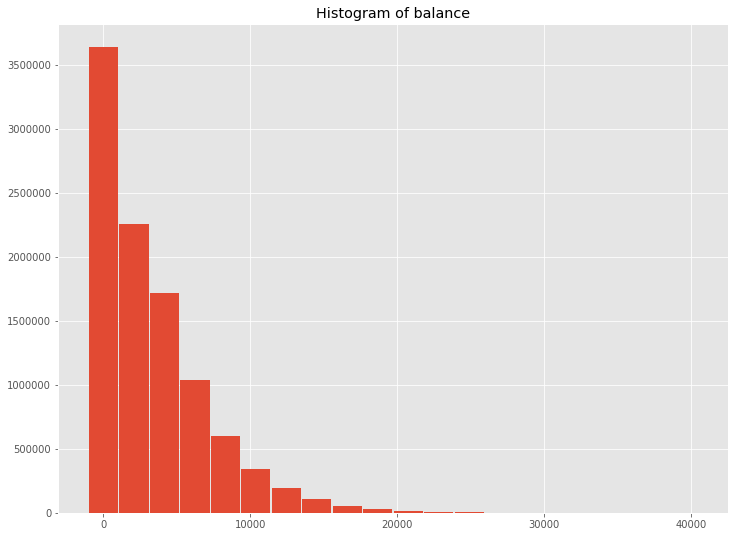

In [250]:
fig = plt.figure(figsize=(12,9))
ax  = fig.add_subplot(1,1,1)

ax.bar(data['bins'], data['freq'], width=2000)
ax.set_title('Histogram of '"balance")

plt.savefig('cc_Histogram.png', dpi =300)

In a similar manner, a histogram can be create with Bokeh.



In [252]:
from bokeh.plotting import figure, show

In [258]:
categories = [str(x) for x in hists[0][:-1] ]
data       = hists[1]

p = figure(x_range= categories)
p.vbar(x=categories, top= data, width =0.9)

show(p)

### Interactions between features

In this example we will sample our fraud dataset at 1% given gender as strata.



In [259]:
data_sample = fraud_df.sampleBy('gender', {1:0.0002, 2:0.0002}).select(numerical)

To put multiple 2D charts in one go you can use



In [ ]:
data_multi = dict([
    (elem, data_sample.select(elem).rdd.flatMap(lambda row: row).collect()) 
    for elem in numerical
])

sctr = chrt.Scatter(data_multi, x='balance', y='numTrans')

chrt.show(sctr)